In [9]:
import os
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import keras
from keras import preprocessing
from keras import layers
from keras import models
from keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns

In [12]:
image_size = (128, 128)
batch_size = 64

train_dir = 'Dataset/Train'

train_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=32,
    subset="training"
)

valid_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=32,
    subset="validation"
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


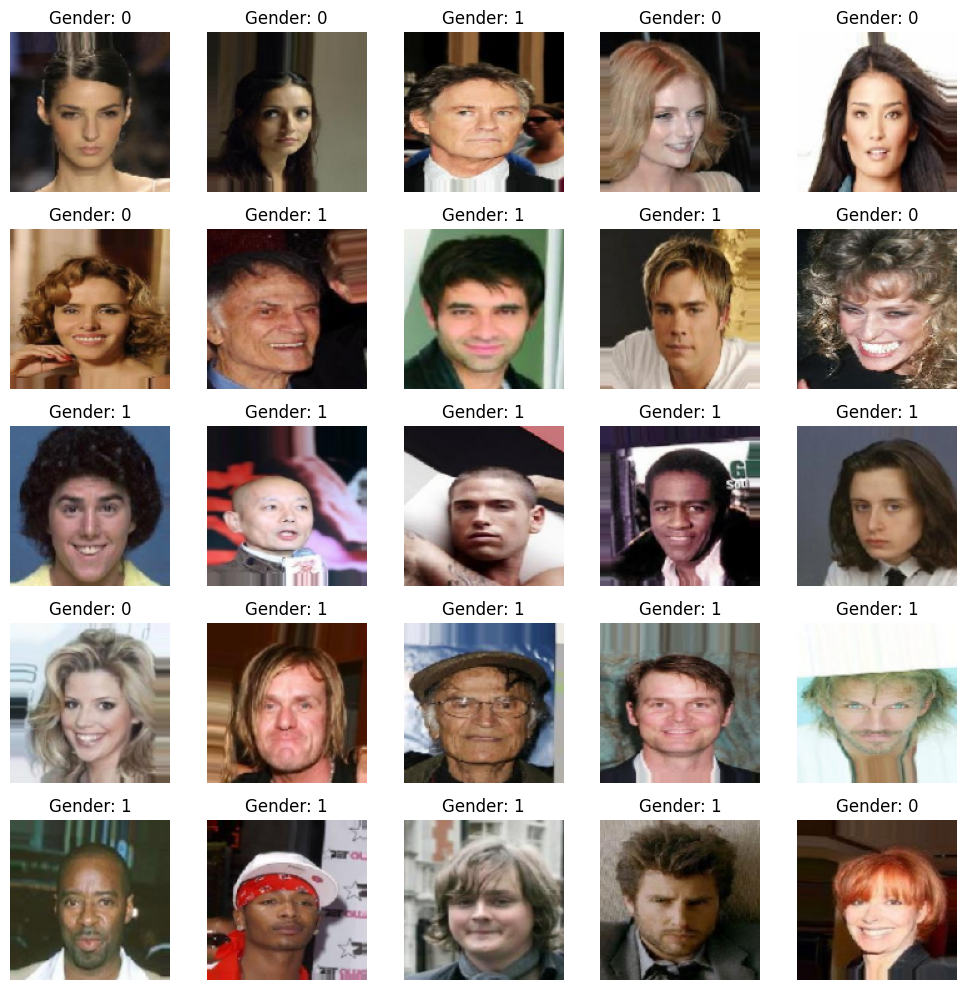

In [13]:
batch = train_generator.next()
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(batch[0][index])
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Gender: {batch[1][index].argmax()}')

plt.tight_layout()
plt.show()

In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

87910968/87910968 [==============================] - 5s 0us/step


In [15]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)

predictions = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=20)


Epoch 1/20
50/50 [==============================] - 56s 359ms/step - loss: 0.4144 - accuracy: 0.8516 - val_loss: 14.3405 - val_accuracy: 0.5000
Epoch 2/20
50/50 [==============================] - 15s 296ms/step - loss: 0.1928 - accuracy: 0.9241 - val_loss: 1.4355 - val_accuracy: 0.5000
Epoch 3/20
50/50 [==============================] - 15s 299ms/step - loss: 0.1639 - accuracy: 0.9372 - val_loss: 0.2480 - val_accuracy: 0.9038
Epoch 4/20
50/50 [==============================] - 15s 296ms/step - loss: 0.1495 - accuracy: 0.9400 - val_loss: 0.1454 - val_accuracy: 0.9525
Epoch 5/20
50/50 [==============================] - 15s 299ms/step - loss: 0.0854 - accuracy: 0.9678 - val_loss: 0.2939 - val_accuracy: 0.9013
Epoch 6/20
50/50 [==============================] - 15s 296ms/step - loss: 0.1154 - accuracy: 0.9619 - val_loss: 0.3574 - val_accuracy: 0.8650
Epoch 7/20
50/50 [==============================] - 15s 297ms/step - loss: 0.0843 - accuracy: 0.9694 - val_loss: 0.3795 - val_accuracy: 0.950

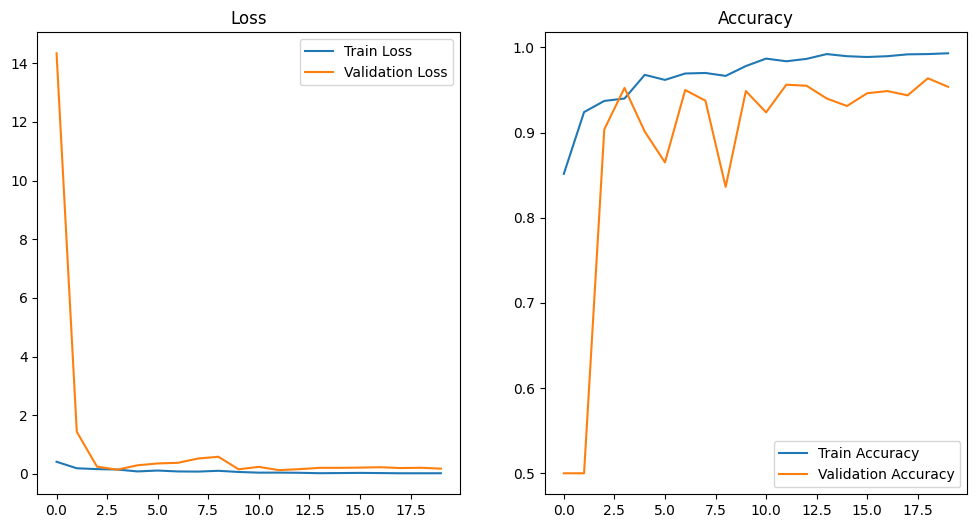

In [17]:
# plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [20]:
# Menggunakan generator data validasi untuk mendapatkan prediksi dan label sebenarnya
y_pred = model.predict(valid_generator)
y_true = valid_generator.classes



13/13 [==============================] - 4s 220ms/step


In [21]:
# Mengonversi prediksi probabilitas menjadi label kategori
y_pred_labels = np.argmax(y_pred, axis=1)

# Nama kelas dari generator data test
class_labels = list(valid_generator.class_indices.keys())

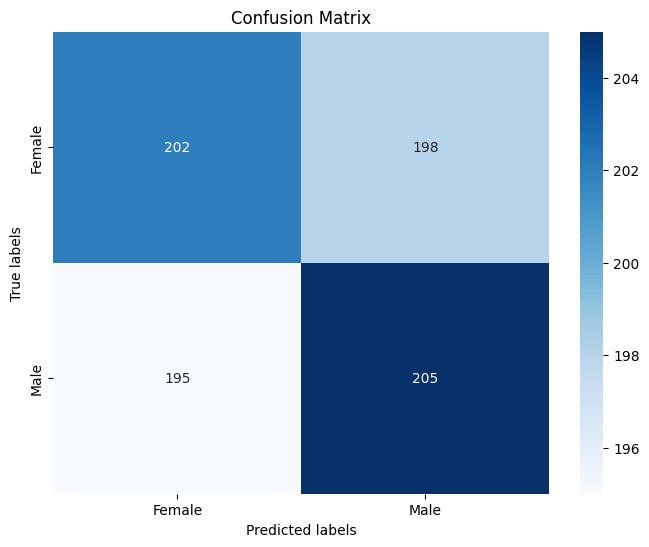

In [22]:


# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid_generator.class_indices.keys(),
            yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

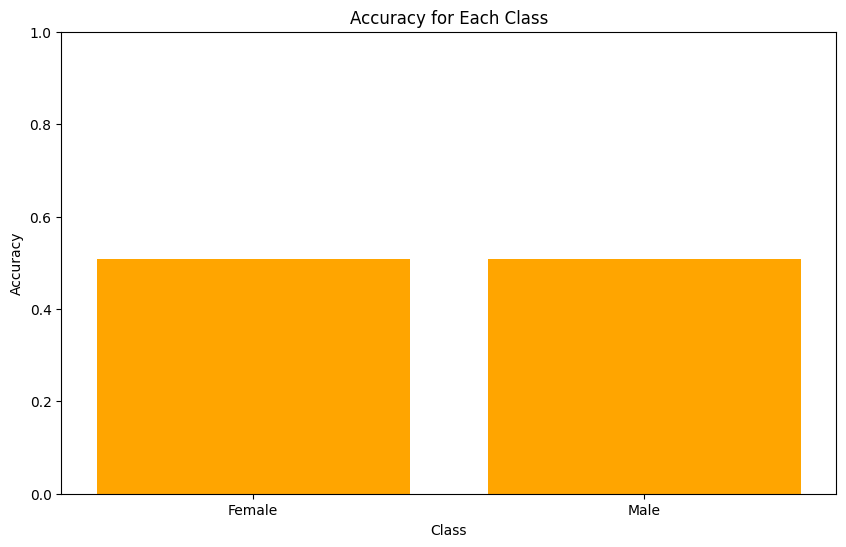

In [23]:
# Menghitung akurasi untuk setiap kelas
accuracy_per_class = accuracy_score(y_true, y_pred_labels)

# Plot akurasi untuk setiap kelas
plt.figure(figsize=(10, 6))
plt.bar(class_labels, accuracy_per_class, color='orange')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.ylim(0, 1)
plt.show()

13/13 [==============================] - 3s 217ms/step


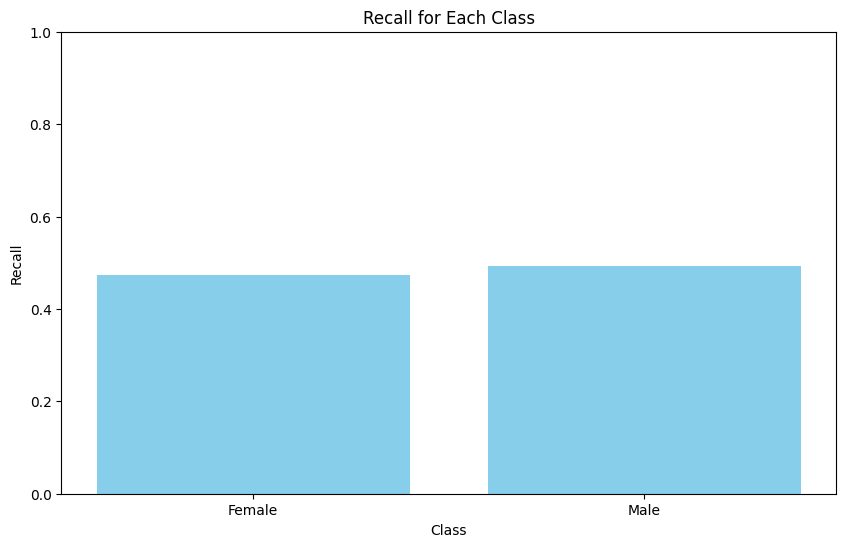

In [24]:
# Menggunakan generator data validasi untuk mendapatkan prediksi dan label sebenarnya
y_pred = model.predict(valid_generator)
y_true = valid_generator.classes

# Mengonversi prediksi probabilitas menjadi label kategori
y_pred_labels = np.argmax(y_pred, axis=1)

# Menghitung recall untuk setiap kelas
recall_per_class = recall_score(y_true, y_pred_labels, average=None)


# Plot recall untuk setiap kelas
plt.figure(figsize=(10, 6))
plt.bar(class_labels, recall_per_class, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for Each Class')
plt.ylim(0, 1)
plt.show()

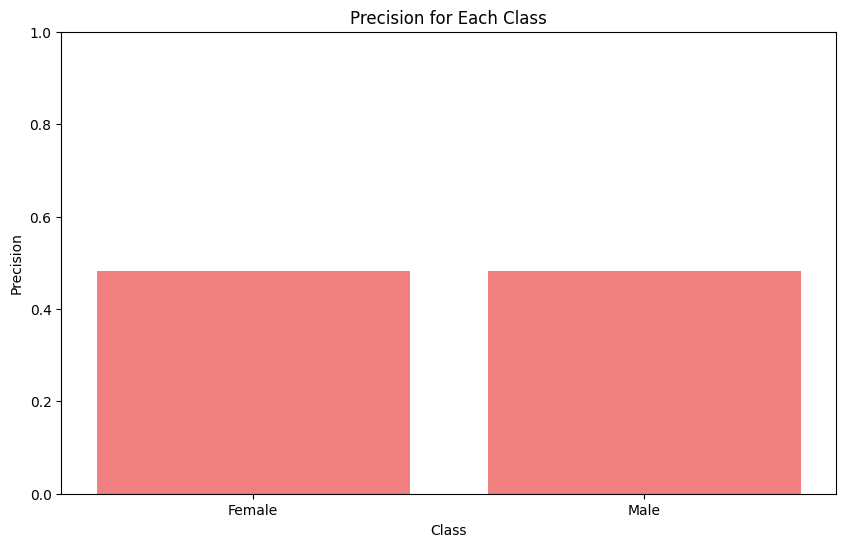

In [25]:
# Menghitung precision untuk setiap kelas
precision_per_class = precision_score(y_true, y_pred_labels, average=None)


# Plot precision untuk setiap kelas
plt.figure(figsize=(10, 6))
plt.bar(class_labels, precision_per_class, color='lightcoral')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for Each Class')
plt.ylim(0, 1)
plt.show()

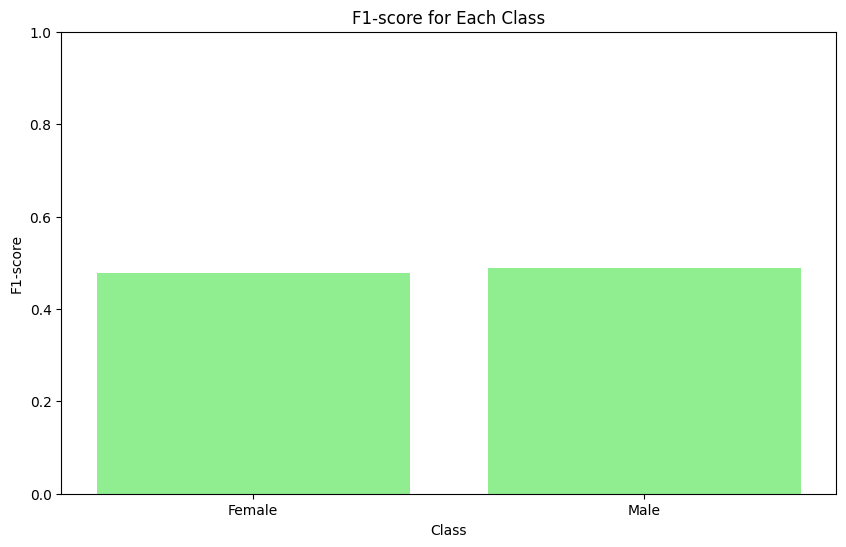

In [26]:
# Menghitung F1-score untuk setiap kelas
f1_per_class = f1_score(y_true, y_pred_labels, average=None)

# Plot F1-score untuk setiap kelas
plt.figure(figsize=(10, 6))
plt.bar(class_labels, f1_per_class, color='lightgreen')
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score for Each Class')
plt.ylim(0, 1)
plt.show()

In [18]:
test_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255)

test_path = "Dataset/Test"
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
  )

# Evaluate the model on test data
evaluation = model.evaluate(test_generator)

# Print evaluation metrics
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

Found 1000 images belonging to 2 classes.
16/16 [==============================] - 3s 163ms/step - loss: 0.1841 - accuracy: 0.9650
Test Loss: 0.18405050039291382
Test Accuracy: 0.9649999737739563


In [28]:
model.save("inception_v3_epochs_20_input_128x128_relu_512.keras")